In [1]:
author_f = 'George'
author_m = ''
author_l = 'Orwell'
antal_verk = 100

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
import pyarrow.parquet as pq
import pyarrow as pa
import pyspark.pandas as ps
import os
import requests
import matplotlib.pyplot as plt

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

def a_url(author_f, author_m, author_l):
    if author_m == '':
        author_url = f"{author_f}+{author_l}"
    else:
        author_url = f"{author_f}+{author_m}+{author_l}"
    return author_url

def search_libris(author_url, antal_verk):
    URL = f"http://libris.kb.se/xsearch?query={author_url}&format=json&n={antal_verk}"
    df = pd.read_json(URL)
    df = df['xsearch']
    df = df['list']
    df = pd.json_normalize(df)
    df_out = df.loc[(df.type=='book')&(df.language=='swe')].reset_index()
    df_out = df_out.drop(columns=['index','identifier','type','publisher','date','description','relation','language'])
    df_out = df_out.explode("isbn")
    df_out = df_out.fillna('Not availible')
    df_out = df_out.reset_index()
    df_out = df_out.drop(columns='index')
    return df_out

def create_clean_search_files(author_url, antal_verk): 
    df_out = search_libris(author_url, antal_verk)
    df_search = df_out[['isbn','title', 'creator']]
    df_search.to_parquet(f'{author_f}_{author_m}_{author_l}.parquet', index=False)
    spark = SparkSession.builder.getOrCreate()
    path = f'{author_f}_{author_m}_{author_l}.parquet'
    parquetFile = spark.read.parquet(path, flavor='spark')
    parquetFile.createOrReplaceTempView("parquetFile")
    query = f"SELECT * FROM parquetFile WHERE creator LIKE '%{author_l}%' AND isbn NOT LIKE '%(invalid)%' AND isbn NOT LIKE '%Not%'"
    df = spark.sql(query)
    dfcsv = df.select('*').toPandas()
    df.show()
    spark.stop()
    dfcsv.to_csv(f'{author_f}_{author_m}_{author_l}.csv', index=False)
    dfcsv.to_parquet(f'{author_f}_{author_m}_{author_l}.parquet', index=False)

def grab_portrait(author_url):

    url_OL1 = 'https://openlibrary.org/search/authors.json?q='+f'{author_url}'
    response = requests.get(url_OL1)
    url_OLD1 = response.json()
    url_OLD1 = url_OLD1['docs']
    df_OL = pd.json_normalize(url_OLD1)
    df_OL.head()
    #df_OL_out = df_OL.loc[(df_OL.key)&(df_OL.name)& (df_OL.alternate_names)&(df_OL.top_work)&(df_OL.top_subjects)].reset_index()
    df_OL_out = df_OL.loc[0]
    df_OL_out
    OL = df_OL_out['key']

    response = requests.get(f'https://openlibrary.org/authors/{OL}', allow_redirects=False)
    #print(response.status_code)
    loc = str(response.headers)
    if "'location':" in loc:
        img_get = loc.split("'location':")[1]
    #    print ('yes')
        img_get = img_get.split(',')[0].replace("'",'')
    #    print(img_get)
    response.close()

    response = requests.get(img_get, allow_redirects=False)
    #print(response.status_code)
    a = str(response.content)
    response.close()

    if "https://covers.openlibrary.org/a/id/" in a:
        b = a.split('>')
        for i in b:
            if "https://covers.openlibrary.org/a/id/" in i:
                img_link = i
    img_link = img_link.split('content=')[1]
    img_link = img_link.split('"')[1]
    #print (img_link)

    url = img_link
    response = requests.get(url)
    with open("image.jpg", "wb") as f:
        f.write(response.content)
    ax = plt.subplots()
    img = plt.imread('image.jpg')
    plt.imshow(img, aspect='auto')
    ax.set_title(f'{img_link}')
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/20 15:15:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------------+--------------------+--------------------+
|         isbn|               title|             creator|
+-------------+--------------------+--------------------+
|9789177030720|Politik och det e...|Orwell, George, 1...|
|   9129410150|Nere för räkning ...|Orwell, George, 1...|
|   9176421341|Nere för räkning ...|Orwell, George, 1...|
|9780008460983|1984 ; and Animal...|Orwell, George, 1...|
|   9174484915|Hyllning till Kat...|Orwell, George, 1...|
+-------------+--------------------+--------------------+

No portrait of author exists


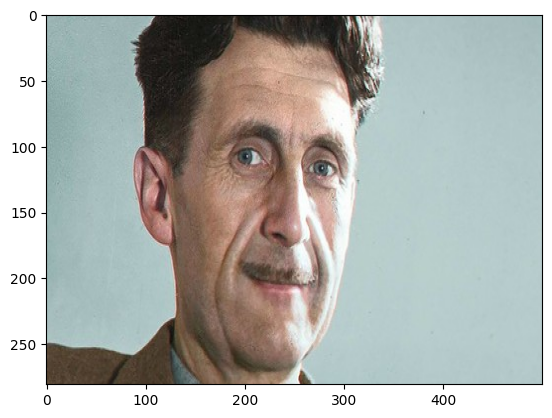

In [3]:
author_url = a_url(author_f, author_m, author_l)
create_clean_search_files(author_url, antal_verk)

try:
    grab_portrait(author_url)
except:
    print('No portrait of author exists')